# 7章 ロジスティクスネットワークの最適設計を行う10本ノック

ここでは、最適化計算を行ういくつかのライブラリを用いて、最適化計算を実際に行っていきます。  
そして、前章で用いたネットワーク可視化などの技術を駆使し、計算結果の妥当性を確認する方法についても学んでいきます。

### ノック６１：輸送最適化問題を解いてみよう

In [1]:
!pip install pulp
!pip install ortoolpy

In [2]:
import numpy as np
import pandas as pd
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars, addvals

In [3]:
# データの読み込み
df_tc = pd.read_csv("trans_cost.csv", index_col="工場")
df_demand = pd.read_csv("demand.csv")
df_supply = pd.read_csv("supply.csv")

In [4]:
df_tc.head()

,F1,F2,F3,F4
工場,,,,
W1,10,10,11,27
W2,18,21,12,14
W3,15,12,14,12


In [5]:
df_demand.head()

,F1,F2,F3,F4
0,28,29,31,25


In [6]:
df_supply.head()

,W1,W2,W3
0,35,41,42


In [7]:
# 初期設定 #
np.random.seed(1)
nw = len(df_tc.index)
nf = len(df_tc.columns)
pr = list(product(range(nw), range(nf)))

# 数理モデル #
m1 = model_min()
v1 = {(i, j): LpVariable('v%d_%d'%(i, j), lowBound=0) for i, j in pr}

m1 += lpSum(df_tc.iloc[i][j]*v1[i, j] for i, j in pr)
for i in range(nw):
    m1 += lpSum(v1[i, j] for j in range(nf)) <= df_supply.iloc[0][i]
for j in range(nf):
    m1 += lpSum(v1[i, j] for i in range(nw)) >= df_demand.iloc[0][j]
m1.solve()

# 総輸送コスト計算 #
df_tr_sol = df_tc.copy()
total_cost = 0
for k, x in v1.items():
    i, j = k[0], k[1]
    df_tr_sol.iloc[i][j] = value(x)
    total_cost += df_tc.iloc[i][j] * value(x)
    
print(df_tr_sol)
print("総輸送コスト:" + str(total_cost))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/shonakamura/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/h8/6j9fnlsn7bq6gh649_gcjkc80000gn/T/0d2d965e86f84126bff279bc6a48bf78-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/h8/6j9fnlsn7bq6gh649_gcjkc80000gn/T/0d2d965e86f84126bff279bc6a48bf78-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 12 COLUMNS
At line 49 RHS
At line 57 BOUNDS
At line 58 ENDATA
Problem MODEL has 7 rows, 12 columns and 24 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 7 (0) rows, 12 (0) columns and 24 (0) elements
0  Obj 0 Primal inf 113 (4)
7  Obj 1296
Optimal - objective value 1296
Optimal objective 1296 - 7 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.01

    F1  F2

### ノック６２：最適輸送ルートをネットワークで確認しよう

In [8]:
import matplotlib.pyplot as plt
import networkx as nx

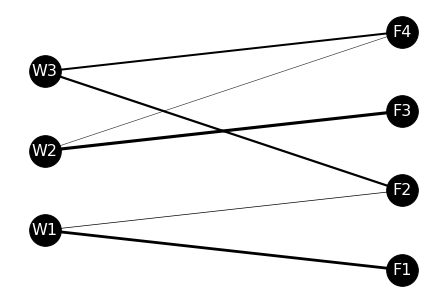

In [9]:
# データ読み込み
df_tr = df_tr_sol.copy()
df_pos = pd.read_csv("trans_route_pos.csv")

# グラフオブジェクト
G = nx.Graph()

# 頂点の設定
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])
    
# 辺の設定＆エッジの重みのリスト化
num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
    for j in range(len(df_pos.columns)):
        if not (i==j):
            # 辺の追加
            G.add_edge(df_pos.columns[i], df_pos.columns[j])
            # エッジの重みの追加
            if num_pre < len(G.edges):
                num_pre = len(G.edges)
                weight = 0
                if (df_pos.columns[i] in df_tr.columns) and (df_pos.columns[j] in df_tr.index):
                    if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
                        weight = df_tr[df_pos.columns[i]][df_pos.columns[j]] * size
                elif (df_pos.columns[j] in df_tr.columns) and (df_pos.columns[i] in df_tr.index):
                    if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
                        weight = df_tr[df_pos.columns[j]][df_pos.columns[i]] * size
                edge_weights.append(weight)
                
# 座標の設定
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0], df_pos[node][1])
    
# 描画
nx.draw(G, pos, with_labels=True, font_size=16, node_size=1000, node_color='k', font_color='w', width=edge_weights)

# 表示
plt.show()

### ノック６３：最適輸送ルートが制約条件内に収まっているかどうかを確認しよう

In [10]:
# データ読み込み
df_demand = pd.read_csv("demand.csv")
df_supply = pd.read_csv("supply.csv")

# 制約条件計算関数
# 需要側
def condition_demand(df_tr, df_demand):
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)):
        temp_sum = sum(df_tr[df_demand.columns[i]])
        if (temp_sum >= df_demand.iloc[0][i]):
            flag[i] = 1
    return flag

# 供給側
def condition_supply(df_tr, df_supply):
    flag = np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if temp_sum <= df_supply.iloc[0][i]:
            flag[i] = 1
    return flag

print("需要条件計算結果：" + str(condition_demand(df_tr_sol, df_demand)))
print("供給条件計算結果：" + str(condition_supply(df_tr_sol, df_supply)))

需要条件計算結果：[1. 1. 1. 1.]
供給条件計算結果：[1. 1. 1.]


### ノック６４：生産計画に関するデータを読み込んでみよう

In [11]:
df_material = pd.read_csv("product_plan_material.csv", index_col="製品")
print(df_material)

df_profit = pd.read_csv("product_plan_profit.csv", index_col="製品")
print(df_profit)

df_stock = pd.read_csv("product_plan_stock.csv", index_col="項目")
print(df_stock)

df_plan = pd.read_csv("product_plan.csv", index_col="製品")
print(df_plan)

     原料1  原料2  原料3
製品                
製品1    1    4    3
製品2    2    4    1
      利益
製品      
製品1  5.0
製品2  4.0
    原料1  原料2  原料3
項目               
在庫   40   80   50
      生産量
製品       
製品1    16
製品2     0


### ノック６５：利益を計算する関数を作ってみよう

In [12]:
# 利益計算関数
def product_plan(df_profit, df_plan):
    profit = 0
    for i in range(len(df_profit.index)):
        for j in range(len(df_plan.columns)):
            profit += df_profit.iloc[i][j] * df_plan.iloc[i][j]
    return profit

print("総利益：" + str(product_plan(df_profit, df_plan)))

総利益：80.0


### ノック６６：生産最適化問題を解いてみよう

In [13]:
from pulp import LpVariable, lpSum, value
from ortoolpy import model_max, addvars, addvals

In [14]:
df = df_material.copy()
inv = df_stock

m = model_max()
v1 = {(i): LpVariable('v%d'%(i), lowBound=0) for i in range(len(df_profit))}
m += lpSum(df_profit.iloc[i] * v1[i] for i in range(len(df_profit)))
for i in range(len(df_material.columns)):
    m += lpSum(df_material.iloc[j, i] * v1[j] for j in range(len(df_profit)) ) <= df_stock.iloc[:, i]
m.solve()

df_plan_sol = df_plan.copy()
for k, x in v1.items():
    df_plan_sol.iloc[k] = value(x)
print(df_plan_sol)
print("総利益：" + str(value(m.objective)))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/shonakamura/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/h8/6j9fnlsn7bq6gh649_gcjkc80000gn/T/f99cf904e32c42cc93936d622770a3bc-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/h8/6j9fnlsn7bq6gh649_gcjkc80000gn/T/f99cf904e32c42cc93936d622770a3bc-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 8 COLUMNS
At line 17 RHS
At line 21 BOUNDS
At line 22 ENDATA
Problem MODEL has 3 rows, 2 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 3 (0) rows, 2 (0) columns and 6 (0) elements
0  Obj -0 Dual inf 8.9999998 (2)
0  Obj -0 Dual inf 8.9999998 (2)
2  Obj 95
Optimal - objective value 95
Optimal objective 95 - 2 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock s

### ノック６７：最適生産計画が制約条件内に収まっているかどうかを確認しよう

In [17]:
# 制約条件計算関数
def condition_stock(df_plan, df_material, df_stock):
    flag = np.zeros(len(df_material.columns))
    for i in range(len(df_material.columns)):
        temp_sum = 0
        for j in range(len(df_material.index)):
            temp_sum = temp_sum + df_material.iloc[j][i] * float(df_plan.iloc[j])
        if (temp_sum <= float(df_stock.iloc[0][i])):
            flag[i] = 1
        print(df_material.columns[i] + " 使用量：" + str(temp_sum) + ", 在庫：" + str(float(df_stock.iloc[0][i])))
    return flag

print("制約条件計算関数：" + str(condition_stock(df_plan_sol, df_material, df_stock)))

原料1 使用量：25.0, 在庫：40.0
原料2 使用量：80.0, 在庫：80.0
原料3 使用量：50.0, 在庫：50.0
制約条件計算関数：[1. 1. 1.]


### ノック６８：ロジスティクスネットワーク設計問題を解いてみよう

In [20]:
製品 = list("AB")
需要地 = list("PQ")
工場 = list("XY")
レーン = (2, 2)

# 輸送費表 #
tbdi = pd.DataFrame(((j, k) for j in 需要地 for k in 工場), columns=["需要地", "工場"])
tbdi["輸送費"] = [1, 2, 3, 1]
tbdi

,需要地,工場,輸送費
0,P,X,1
1,P,Y,2
2,Q,X,3
3,Q,Y,1


In [19]:
# 需要表 #
tbde = pd.DataFrame(((j, i) for j in 需要地 for i in 製品), columns=["需要地", "製品"])
tbde["需要"] = [10, 10, 20, 20]
tbde

,需要地,製品,需要
0,P,A,10
1,P,B,10
2,Q,A,20
3,Q,B,20


In [23]:
# 生産表 #
tbfa = pd.DataFrame(((k, l, i, 0, np.inf) for k, nl in zip(工場, レーン) for l in range(nl) for i in 製品), 
                     columns=["工場", "レーン", "製品", "下限", "上限"])
tbfa["生産費"] = [1, np.nan, np.nan, 1, 3, np.nan, 5, 3]
tbfa.dropna(inplace=True)
tbfa.loc[4, "上限"] = 10
tbfa

,工場,レーン,製品,下限,上限,生産費
0,X,0,A,0,inf,1.0
3,X,1,B,0,inf,1.0
4,Y,0,A,0,10.0,3.0
6,Y,1,A,0,inf,5.0
7,Y,1,B,0,inf,3.0


In [24]:
from ortoolpy import logistics_network

In [25]:
_, tbdi2, _ = logistics_network(tbde, tbdi, tbfa)
tbfa

/Users/shonakamura/opt/anaconda3/lib/python3.9/site-packages/ortoolpy/etc.py:1213: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  tbsm = pd.concat([tbdi2.groupby(facprd).VarX.sum(), tbfa.groupby(facprd).VarY.sum()], 1)


,工場,レーン,製品,下限,上限,生産費,VarY,ValY
0,X,0,A,0,inf,1.0,v000009,20.0
3,X,1,B,0,inf,1.0,v000010,10.0
4,Y,0,A,0,10.0,3.0,v000011,10.0
6,Y,1,A,0,inf,5.0,v000012,0.0
7,Y,1,B,0,inf,3.0,v000013,20.0


In [26]:
tbdi2

,需要地,工場,輸送費,製品,VarX,ValX
0,P,X,1,A,v000001,10.0
1,P,X,1,B,v000002,10.0
2,Q,X,3,A,v000003,10.0
3,Q,X,3,B,v000004,0.0
4,P,Y,2,A,v000005,0.0
5,P,Y,2,B,v000006,0.0
6,Q,Y,1,A,v000007,10.0
7,Q,Y,1,B,v000008,20.0


### ノック６９：最適ネットワークにおける輸送コストとその内訳を計算しよう

In [27]:
print(tbdi2)
trans_cost = 0
for i in range(len(tbdi2.index)):
    trans_cost += tbdi2["輸送費"].iloc[i] * tbdi2["ValX"].iloc[i]
print("総輸送コスト:" + str(trans_cost))

  需要地 工場  輸送費 製品     VarX  ValX
0   P  X    1  A  v000001  10.0
1   P  X    1  B  v000002  10.0
2   Q  X    3  A  v000003  10.0
3   Q  X    3  B  v000004   0.0
4   P  Y    2  A  v000005   0.0
5   P  Y    2  B  v000006   0.0
6   Q  Y    1  A  v000007  10.0
7   Q  Y    1  B  v000008  20.0
総輸送コスト:80.0


### ノック７０：最適ネットワークにおける生産コストとその内訳を計算しよう

In [28]:
print(tbfa)
product_cost = 0
for i in range(len(tbfa.index)):
    product_cost += tbfa["生産費"].iloc[i] * tbfa["ValY"].iloc[i]
print("総生産コスト:" + str(product_cost))

  工場  レーン 製品  下限    上限  生産費     VarY  ValY
0  X    0  A   0   inf  1.0  v000009  20.0
3  X    1  B   0   inf  1.0  v000010  10.0
4  Y    0  A   0  10.0  3.0  v000011  10.0
6  Y    1  A   0   inf  5.0  v000012   0.0
7  Y    1  B   0   inf  3.0  v000013  20.0
総生産コスト:120.0
